# Anomaly Detection

Anomaly or outlier detection is essentially finding patterns that do not conform to expected behavior. There are several approaches to anomaly detection that are based on either statistical properties, clustering, classification, Principal Component Analysis (PCA), or subsampling. In this notebook we will look at an **autoencoder network** for anomaly or outlier detection. An autoencoder is a neural-net based, unsupervised learning model that is used to learn low-dimensional features that captures some structure underlying the high-dimensional input data.

## Lab Scenario

Groundwater level is an important metric, especially for agriculture states such as Iowa. One of the metrics [U.S. Geological Survey (USGS)](https://www.usgs.gov/) monitors is **depth to water level in feet below the land**. In this lab we will use a synthetic dataset that models certain scenarios for Des Moines, Iowa. The three key weather-related metrics we will be using are:

- water-level (depth to water level in feet below the land)
- temperature
- humidity

The data is generated daily using realistic monthly averages for Des Moines, Iowa, for the years 2016 – 2019.

We are going to be using 3 copies of the dataset for years 2016 -2019: 

1. Normal conditions for the region.
2. A sudden precipitous rainfall abnormally raising ground water levels that occurs in mid-May 2019.
3. A gradual build up dry conditions dropping the ground water levels that occur over the months of June and July 2019.

## Outline

1. **Introduction to the datasets**: Understand the patterns in the three datasets – normal, sudden and gradual.

2. **Define and train the Autoencoder Network**: Use Keras to define and train the autoencoder model.

3. **Establish criteria for anomalies**: Define approaches and thresholds for detecting anomalies based on the trained autoencoder model.

4. **Predict anomalies**: Used in the trained autoencoder model, make predictions on the sudden and gradual dataset to identify anomalies.

5. **Principal Component Analysis**: Apply PCA on the encoded dataset and visualize the data representation at lower dimensions.

### Import required libraries 

In [8]:
import pandas as pd
import numpy as np
np.random.seed(293)
import math
from IPython.display import display, HTML, Image, SVG
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
print("pandas version: {} numpy version: {}".format(pd.__version__, np.__version__))

import sklearn
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn_pandas import DataFrameMapper

import keras
import tensorflow
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

from numpy.random import seed
from tensorflow import set_random_seed

print("keras version: {} tensorflow version: {} sklearn version: {}".format(keras.__version__, 
                                                                        tensorflow.__version__, sklearn.__version__))

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

print('importing libraries done!')

pandas version: 0.25.1 numpy version: 1.16.4
keras version: 2.2.4 tensorflow version: 1.14.0 sklearn version: 0.21.3
importing libraries done!


**Helper method to display a pandas dataframe**

In [9]:
def display_dataframe(df_in):
    s = df_in.style.set_properties(**{'text-align': 'left'})
    s.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    display(HTML(s.render()))

## Introduction to the Datasets

**Load the three datasets**

In [10]:
normal_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
              'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/anomaly_detection/normal.xlsx')

sudden_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
              'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/anomaly_detection/sudden.xlsx')

gradual_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
               'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/anomaly_detection/gradual.xlsx')

normal_df = pd.read_excel(normal_url)
sudden_df = pd.read_excel(sudden_url)
gradual_df = pd.read_excel(gradual_url)

### Pair Plots

Visualize the pair-wise relationships in the three data sets for the three-key metrics: (1) temperature, (2) humidity, and (3) water-level.

#### Normal Dataset

The water-level appears to be normally distributed around the peak value of 17 feet. It is important to note that that **higher water-level number represents dry conditions** and **lower water-level number represents wet conditions**. 

No natural clusters between water-level and temperature, whereas two distinct clusters between water-level and humidity.

<IPython.core.display.Javascript object>


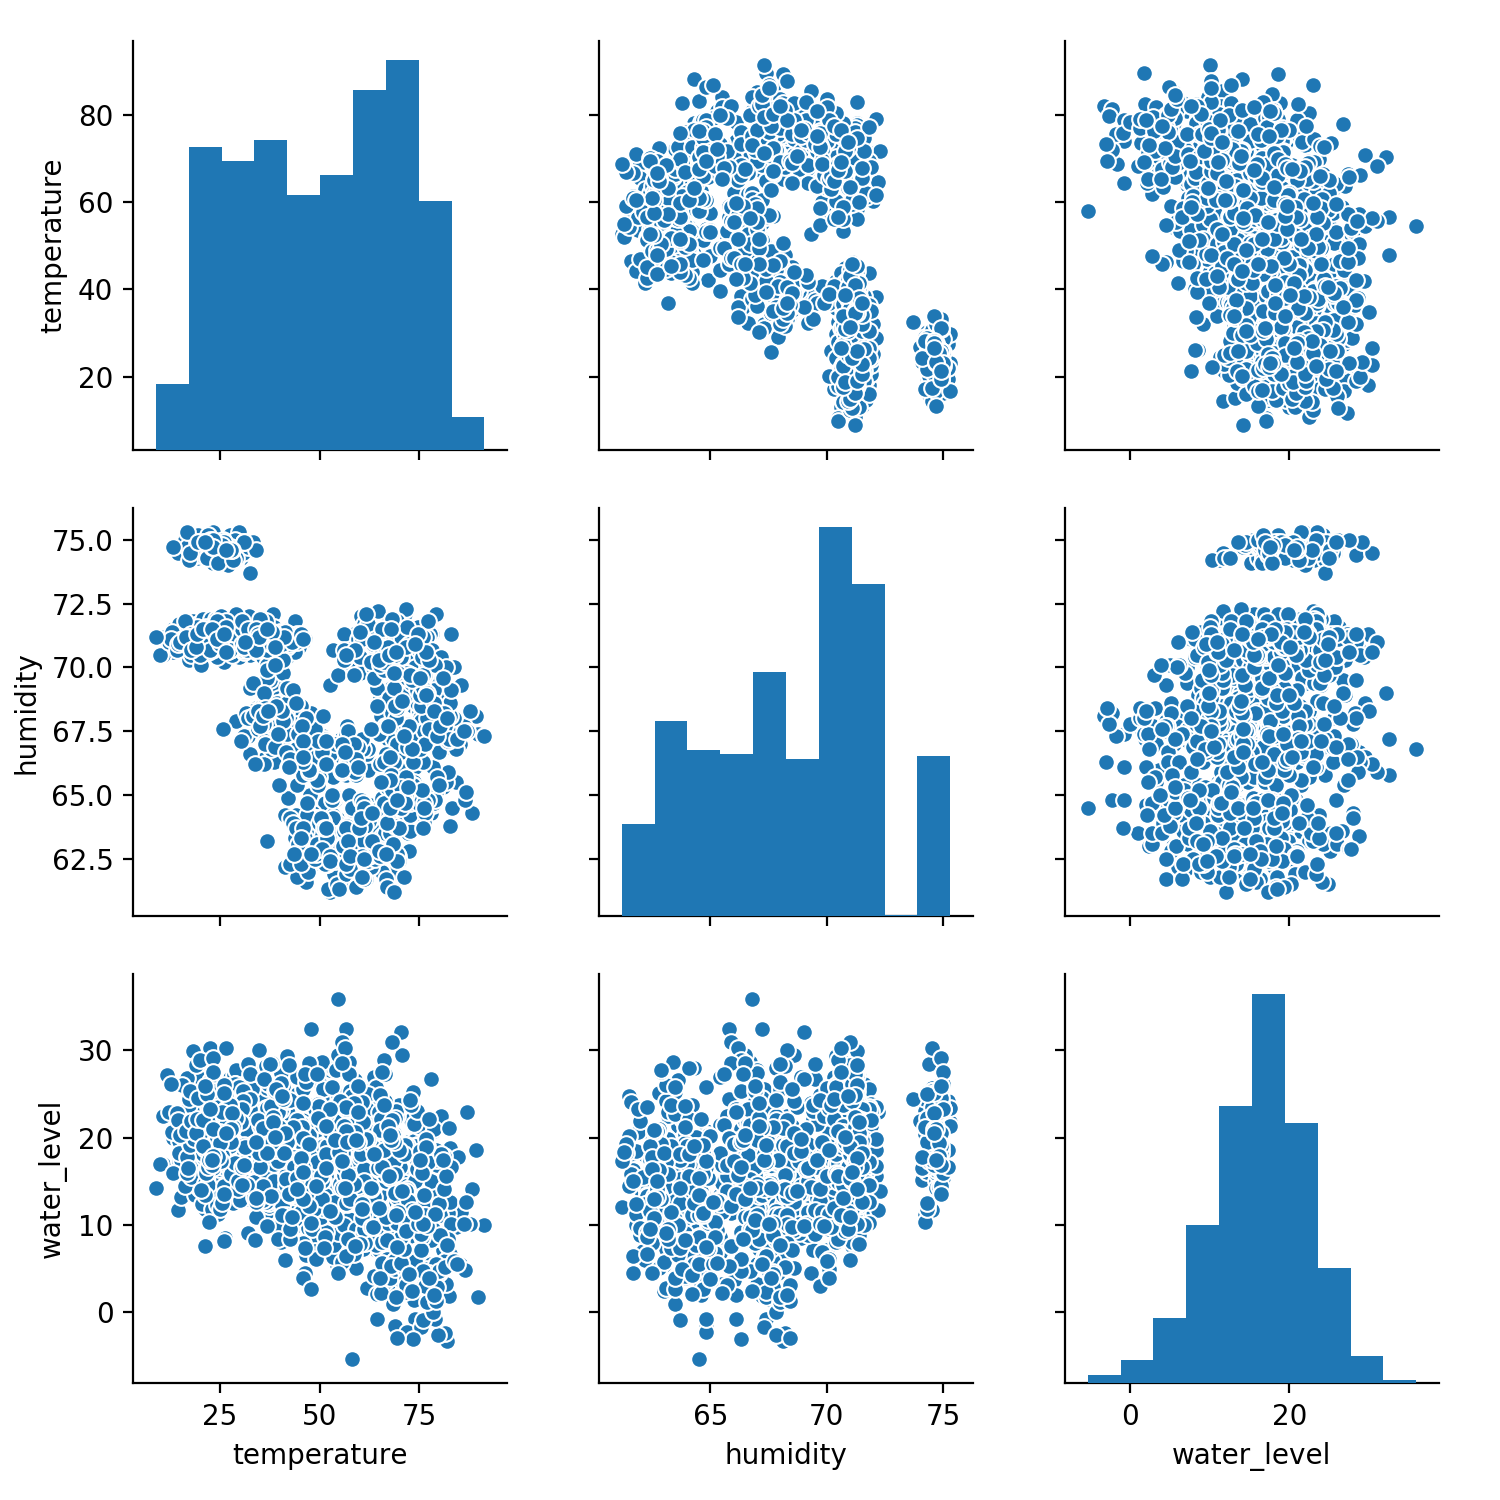

In [5]:
cols = ['temperature', 'humidity', 'water_level']
sns.pairplot(normal_df[cols])

#### Sudden Dataset

Note that in this dataset we have introduced sudden precipitous rainfall that suddenly and temporarily raised ground water levels around mid-May 2019 till end of May 2019.

No visible change in the pair wise distributions.

<IPython.core.display.Javascript object>


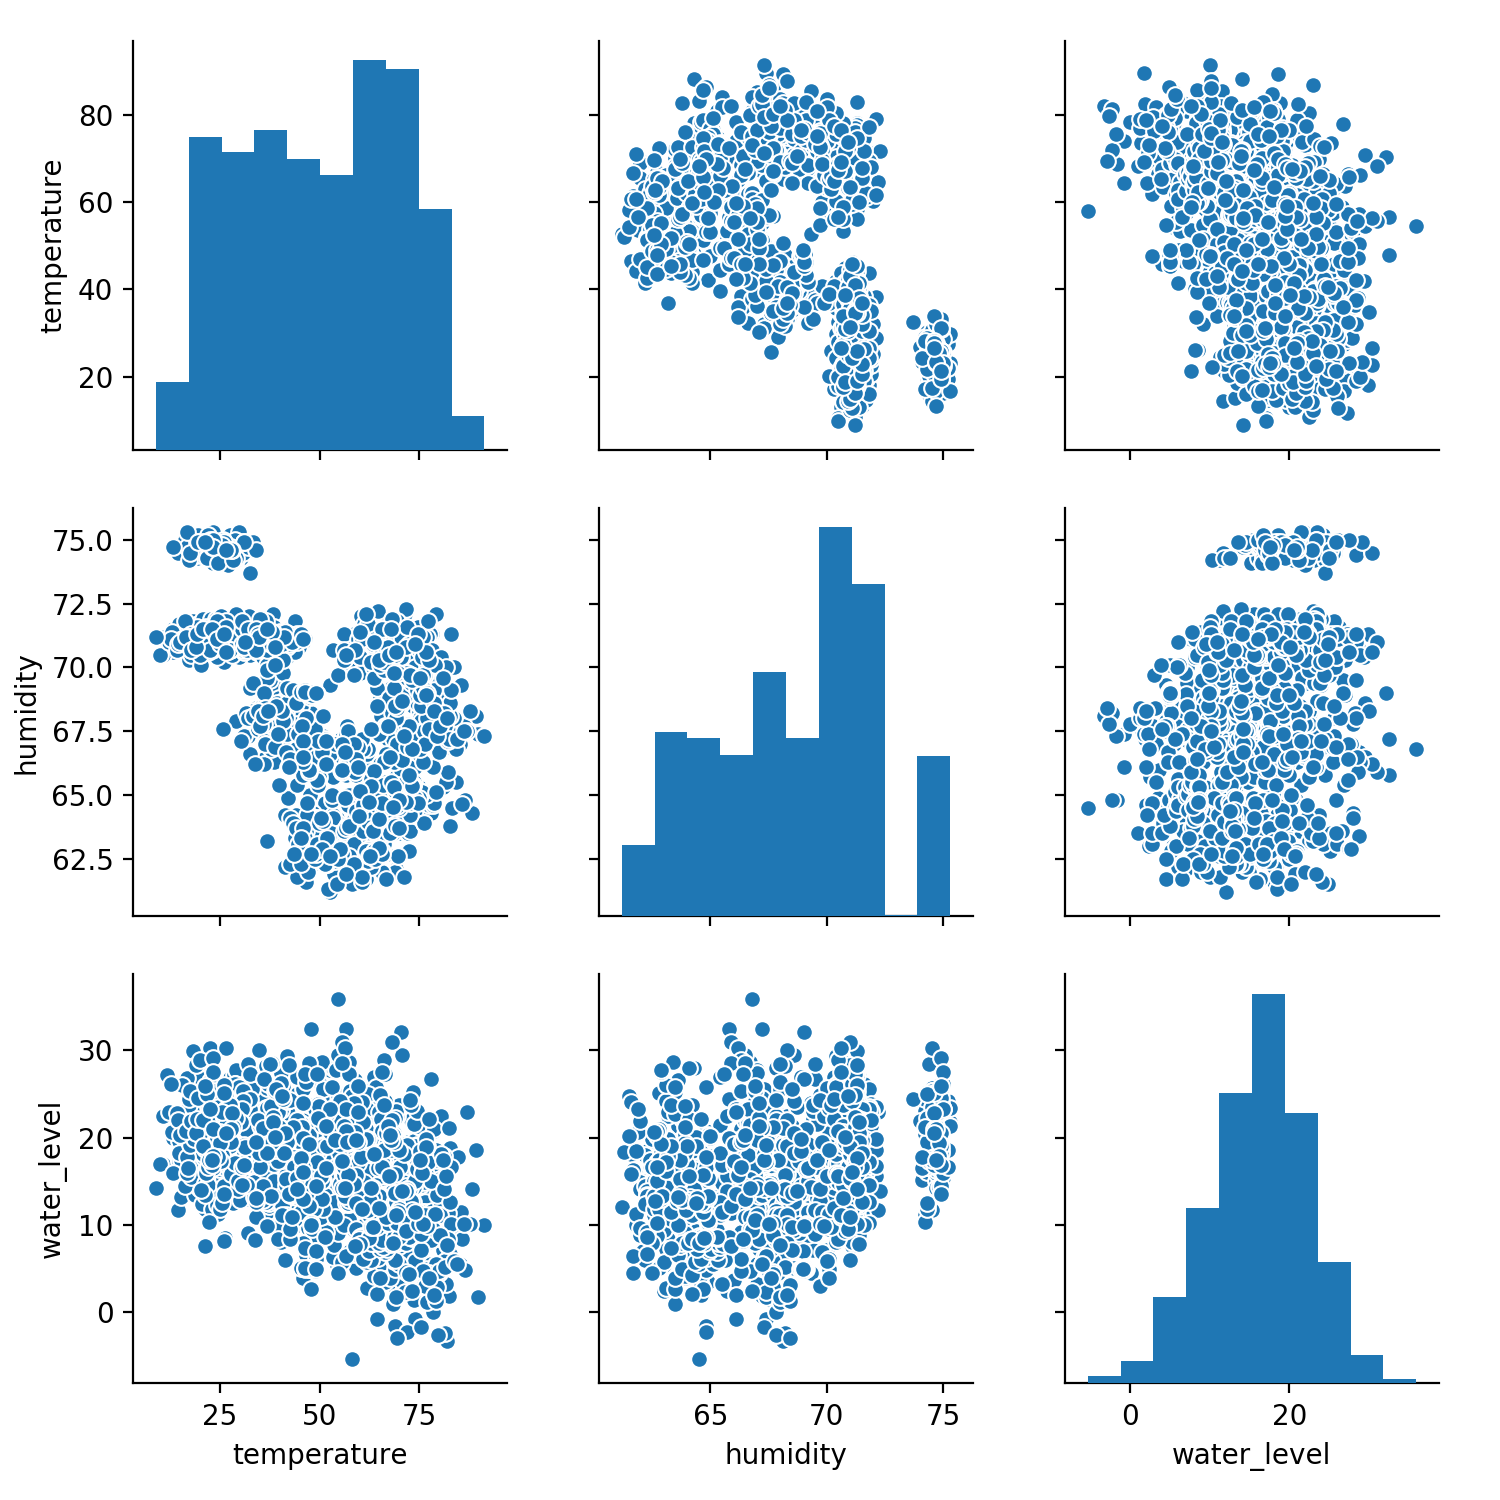

In [6]:
sns.pairplot(sudden_df[cols])

#### Gradual Dataset

Note that this dataset emulates gradual build up dry conditions over the months of June and July 2019 that unseasonably dropped the water levels.

No visible change in the pair wise distributions.

<IPython.core.display.Javascript object>


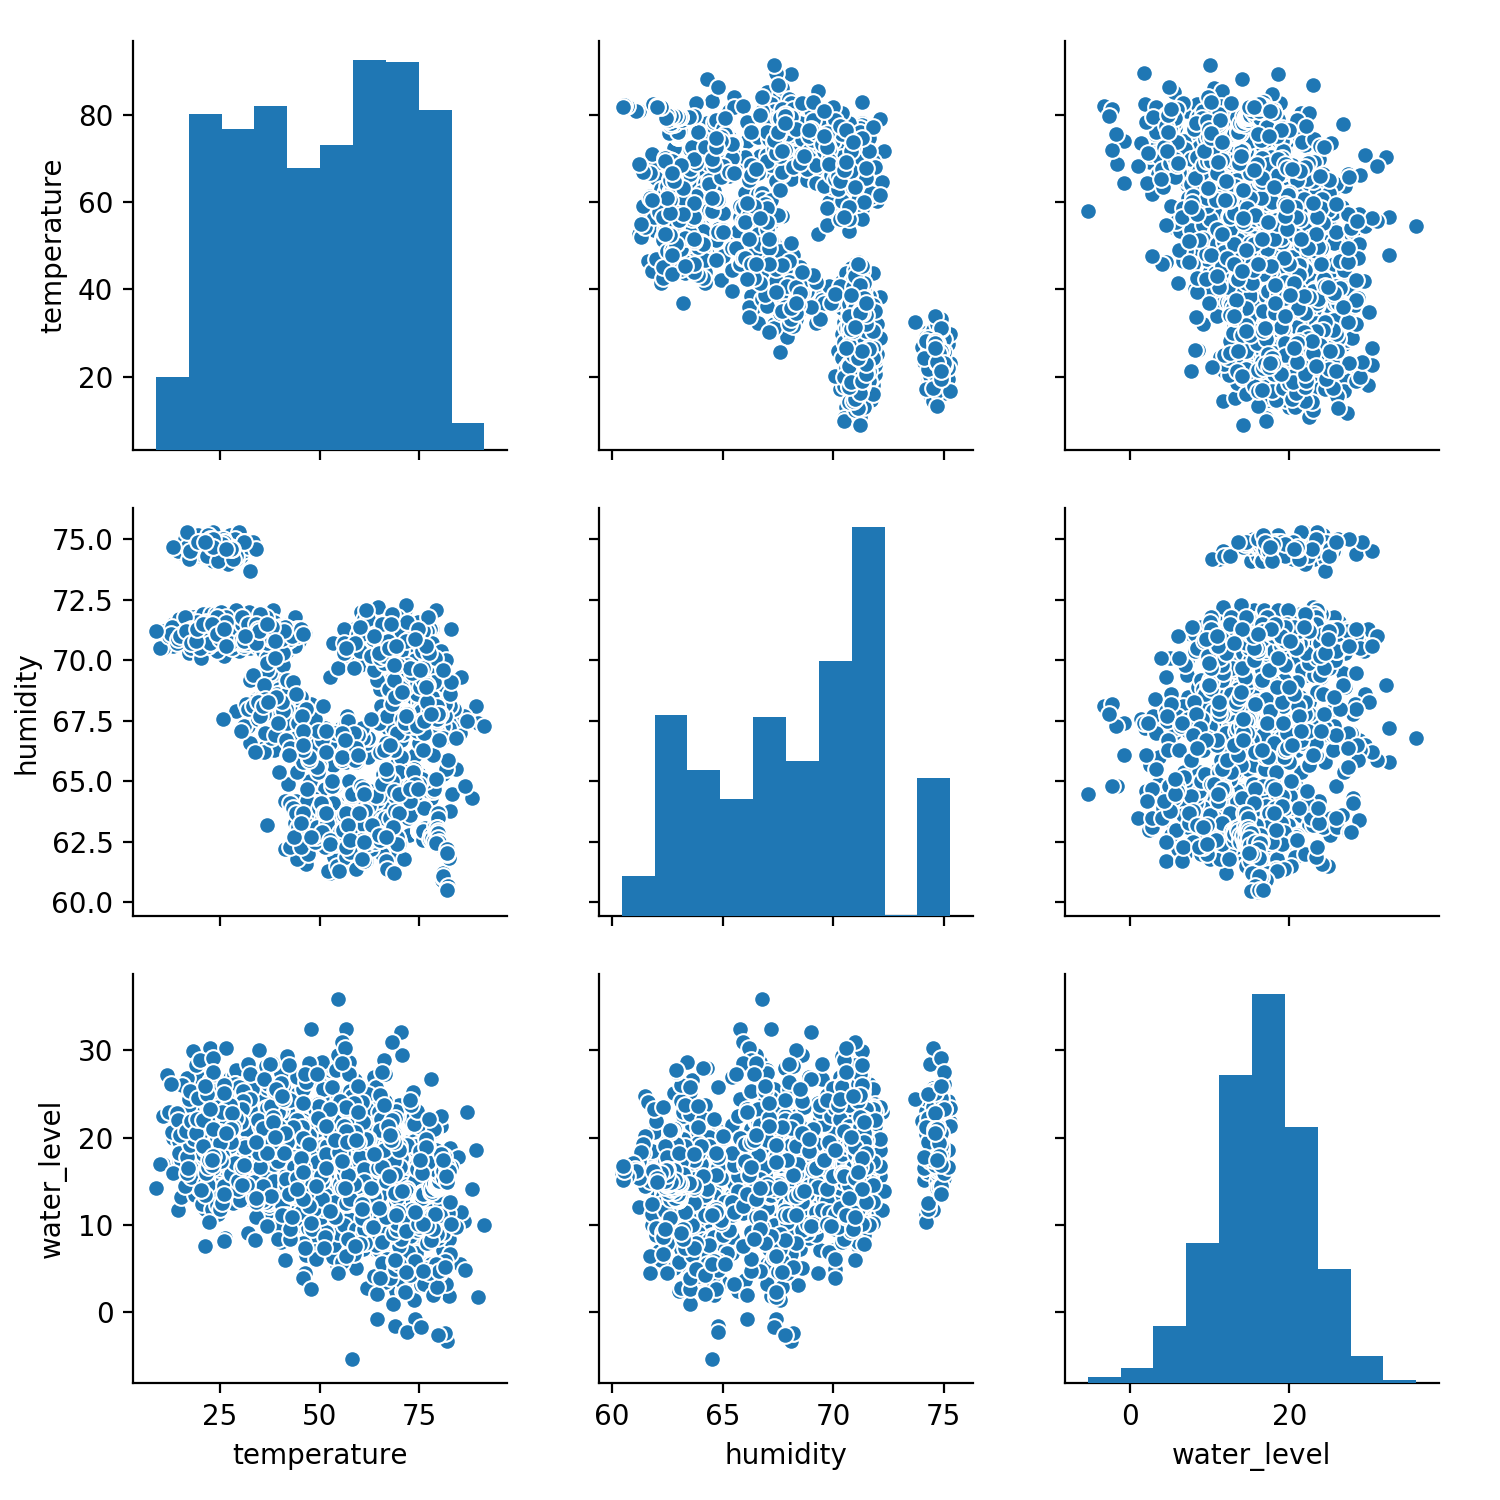

In [7]:
sns.pairplot(gradual_df[cols])

### Water Level Plots

#### Box and Whisker Plot

In a box and whisker plot: the ends of the box are the upper and lower quartiles, so the box spans the interquartile range. the median is marked by a horizontal line inside the box. The whiskers are the two lines outside the box indicating variability outside the upper and lower quartiles. Outliers are plotted as individual points.

The plot shows what is normal changes from month to month. The summer months of June and July are relatively wet month from ground water level perspective presumably due to precipitations from earlier months. Maintaining reliable monthly water levels is critical to the agricultural needs.

In this visualization, there is not obvious evidence of the induced anomalies in the sudden and gradual datasets.

<IPython.core.display.Javascript object>


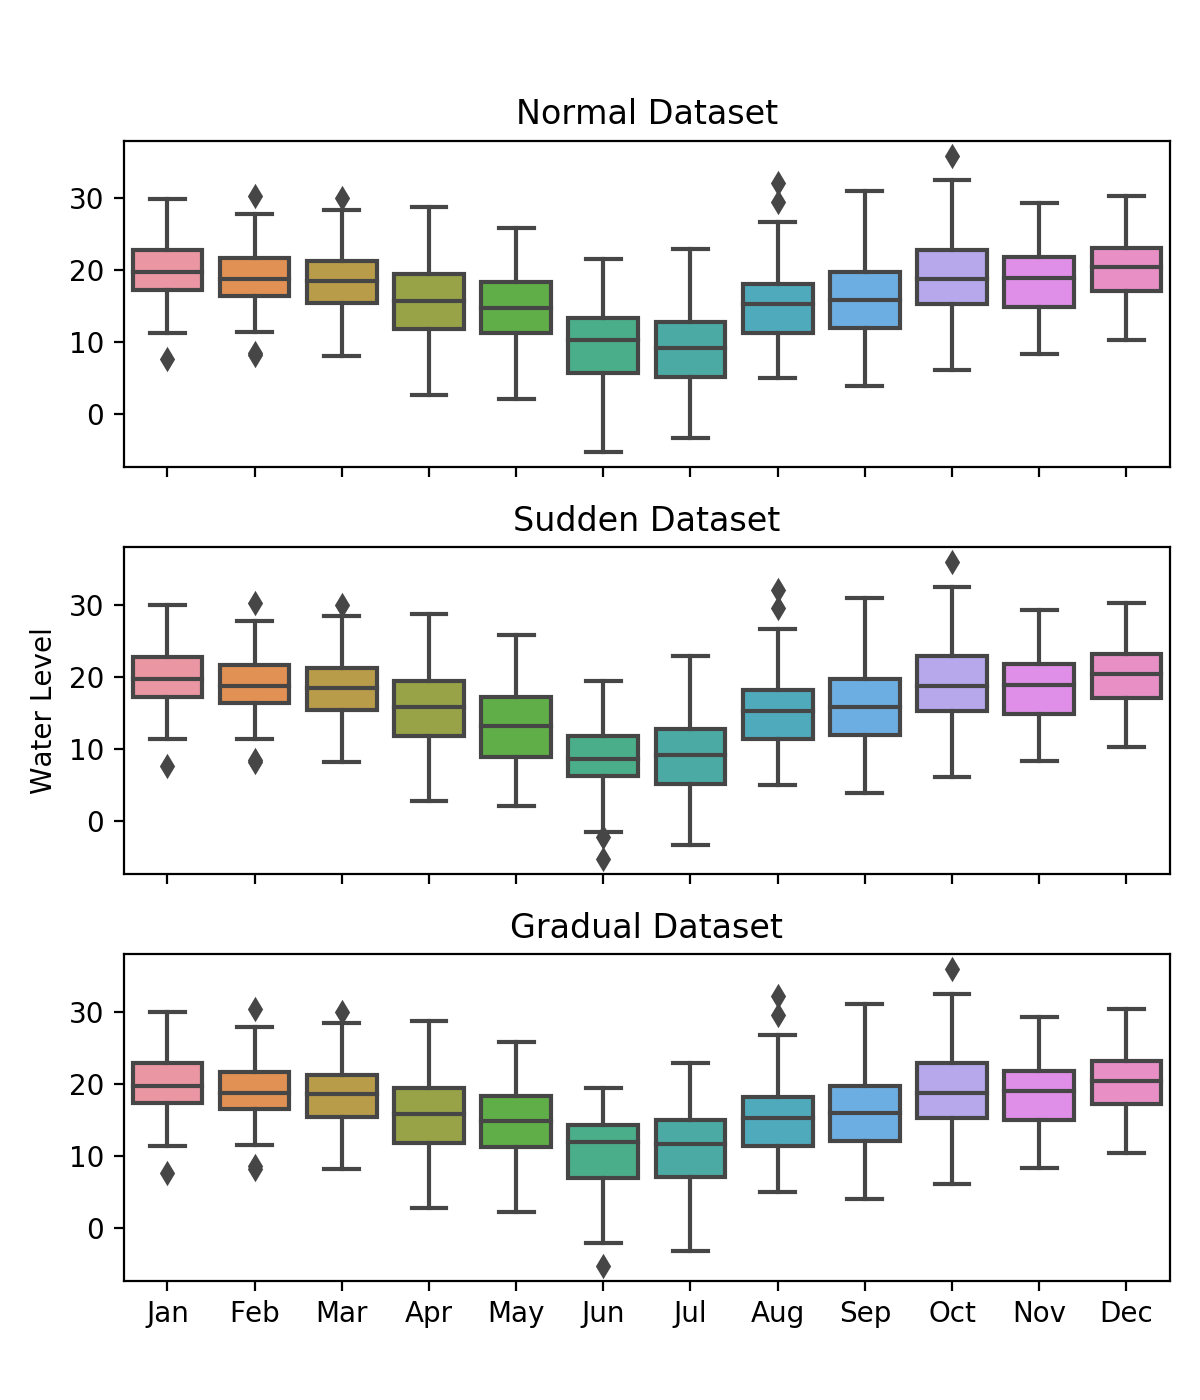

In [16]:
f, axes = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(6, 7))

ax1 = sns.boxplot(x="month_name", y="water_level", data=normal_df, ax=axes[0])
ax2 = sns.boxplot(x="month_name", y="water_level", data=sudden_df, ax=axes[1])
ax3 = sns.boxplot(x="month_name", y="water_level", data=gradual_df, ax=axes[2])

ax1.set_title('Normal Dataset')
ax2.set_title('Sudden Dataset')
ax3.set_title('Gradual Dataset')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax1.set_ylabel('')
ax2.set_ylabel('Water Level')
ax3.set_ylabel('')

f.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Daily Trend Plot

This plot shows daily `Water Level` reading for years 2016-2019 (1461 days).

In this historic view of the data, you can observer the induced anomalies in the sudden and the gradual datasets. In the sudden dataset, the `Water Level` suddenly rises, and in the gradual dataset, the `Water Level` gradually drops over a period of time.

In this notebook we are going to develop an anomaly detection model that allows us to detect such anomalies in real-time.

<IPython.core.display.Javascript object>


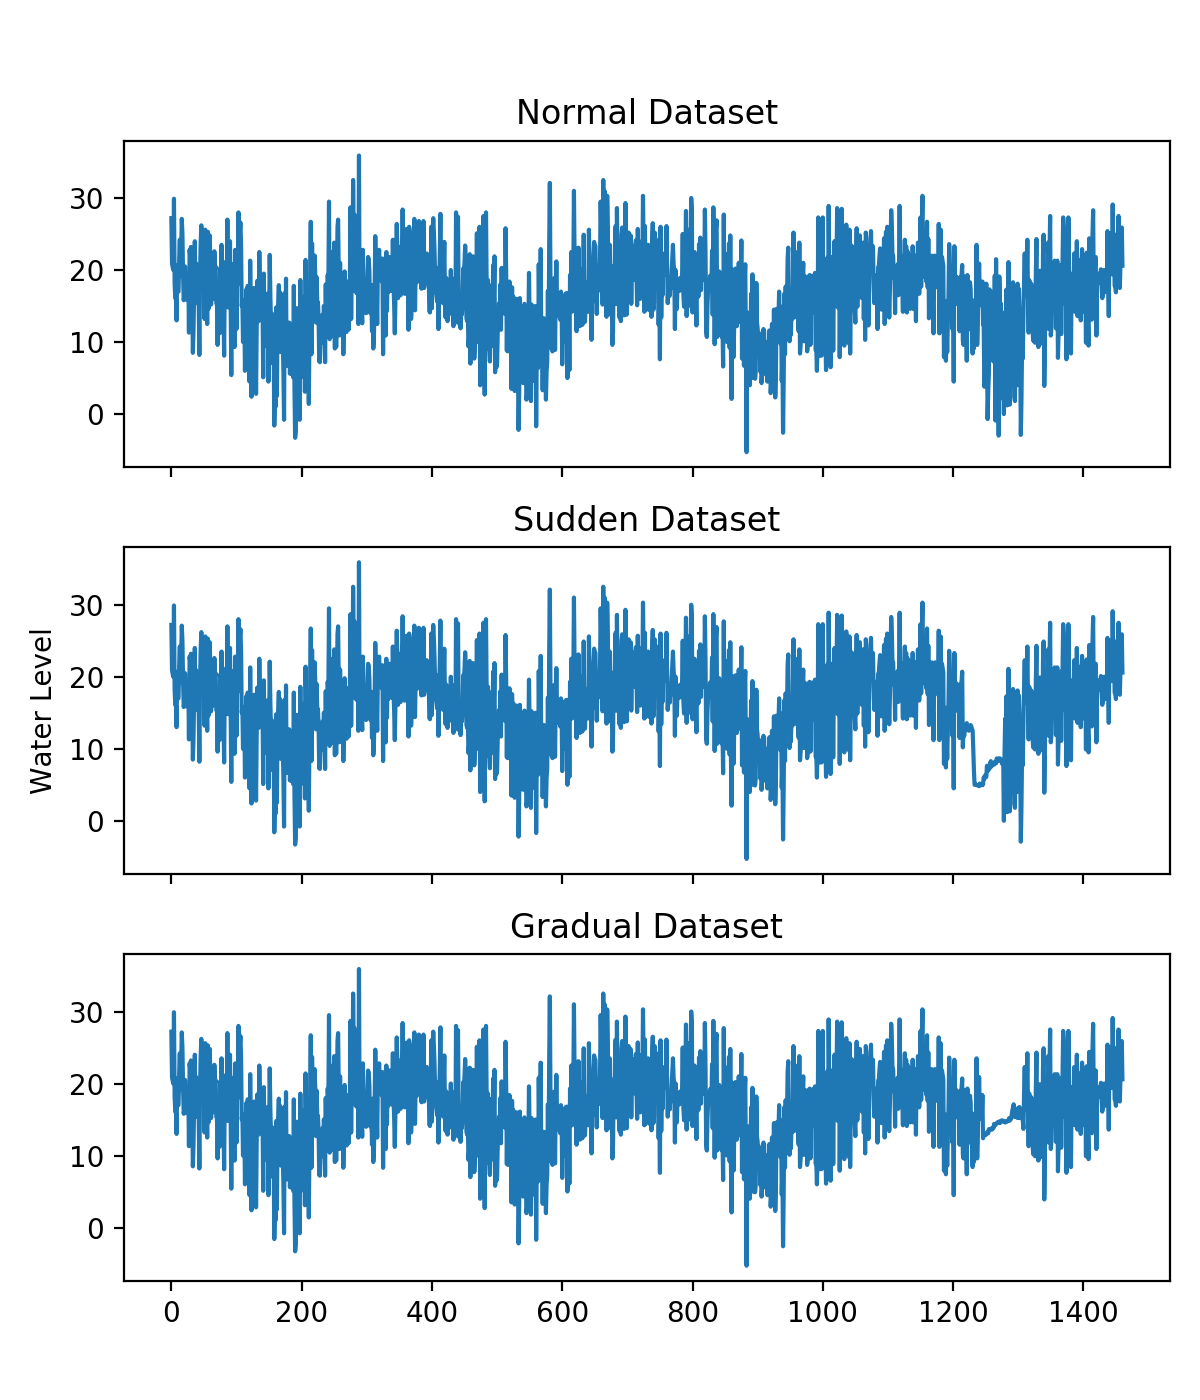

In [17]:
f, ax = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(6, 7))
ax[0].plot(normal_df.water_level)
ax[1].plot(sudden_df.water_level)
ax[2].plot(gradual_df.water_level)
ax[0].set_title('Normal Dataset')
ax[1].set_title('Sudden Dataset')
ax[2].set_title('Gradual Dataset')
ax[1].set_ylabel('Water Level')
f.tight_layout(rect=[0, 0.03, 1, 0.95])

## Define and Train the Autoencoder Network

### Preprocess Input Data

Select **month**, **temperature**, **humidity**, and **water level** as our features for the network.

In [23]:
feature_cols = ['month', 'temperature', 'humidity', 'water_level']
categorical = ['month']
numerical = ['temperature', 'humidity', 'water_level']

numeric_transformations = [([f], Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])) for f in numerical]
    
categorical_transformations = [([f], OneHotEncoder(handle_unknown='ignore', sparse=False)) for f in categorical]

transformations = categorical_transformations + numeric_transformations

clf = Pipeline(steps=[('preprocessor', DataFrameMapper(transformations))])

X_train = clf.fit_transform(normal_df[feature_cols])
np.random.shuffle(X_train)

### Define the Autoencoder Network Architecture

In [168]:
seed(10)
set_random_seed(10)
act_func = 'elu'

input_ = Input(shape=(X_train.shape[1],))
x = Dense(50, activation=act_func)(input_)
x = Dense(25, activation=act_func)(x)
encoder = Dense(10, activation=act_func, name='feature_vector')(x)
x = Dense(25, activation=act_func)(encoder)
x = Dense(50, activation=act_func)(x)
output_ = Dense(X_train.shape[1], activation=act_func)(x)

model = Model(input_, output_)
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer=opt)

encoder_model = Model(inputs=model.input, outputs=model.get_layer('feature_vector').output)
encoder_model.compile(loss='mse', optimizer='adam')

### Train the Autoencoder Model

In [169]:
epochs = 800
batch_size = 16

history = model.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, validation_split=0.05, verbose=1)

Train on 1387 samples, validate on 74 samples
Epoch 1/800
1387/1387 [==============================] - 2s 1ms/step - loss: 0.0999 - val_loss: 0.0764
Epoch 2/800
1387/1387 [==============================] - 0s 125us/step - loss: 0.0679 - val_loss: 0.0608
Epoch 3/800
1387/1387 [==============================] - 0s 126us/step - loss: 0.0563 - val_loss: 0.0522
Epoch 4/800
1387/1387 [==============================] - 0s 146us/step - loss: 0.0486 - val_loss: 0.0456
Epoch 5/800
1387/1387 [==============================] - 0s 112us/step - loss: 0.0424 - val_loss: 0.0401
Epoch 6/800
1387/1387 [==============================] - 0s 122us/step - loss: 0.0374 - val_loss: 0.0356
Epoch 7/800
1387/1387 [==============================] - 0s 125us/step - loss: 0.0332 - val_loss: 0.0320
Epoch 8/800
1387/1387 [==============================] - 0s 122us/step - loss: 0.0298 - val_loss: 0.0289
Epoch 9/800
1387/1387 [==============================] - 0s 112us/step - loss: 0.0271 - val_loss: 0.0265
Epoch 10/80

Epoch 147/800
1387/1387 [==============================] - 0s 168us/step - loss: 1.5313e-04 - val_loss: 1.4242e-04
Epoch 148/800
1387/1387 [==============================] - 0s 161us/step - loss: 1.5331e-04 - val_loss: 1.3280e-04
Epoch 149/800
1387/1387 [==============================] - 0s 135us/step - loss: 1.4894e-04 - val_loss: 1.3609e-04
Epoch 150/800
1387/1387 [==============================] - 0s 127us/step - loss: 1.4963e-04 - val_loss: 1.2971e-04
Epoch 151/800
1387/1387 [==============================] - 0s 130us/step - loss: 1.4683e-04 - val_loss: 1.2422e-04
Epoch 152/800
1387/1387 [==============================] - 0s 134us/step - loss: 1.4639e-04 - val_loss: 1.2045e-04
Epoch 153/800
1387/1387 [==============================] - 0s 107us/step - loss: 1.4464e-04 - val_loss: 1.2379e-04
Epoch 154/800
1387/1387 [==============================] - 0s 100us/step - loss: 1.4281e-04 - val_loss: 1.2295e-04
Epoch 155/800
1387/1387 [==============================] - 0s 159us/step - loss:

1387/1387 [==============================] - 0s 97us/step - loss: 4.5794e-05 - val_loss: 3.9097e-05
Epoch 290/800
1387/1387 [==============================] - 0s 98us/step - loss: 4.6642e-05 - val_loss: 4.4100e-05
Epoch 291/800
1387/1387 [==============================] - 0s 98us/step - loss: 4.6134e-05 - val_loss: 4.3658e-05
Epoch 292/800
1387/1387 [==============================] - 0s 97us/step - loss: 4.5097e-05 - val_loss: 4.3520e-05
Epoch 293/800
1387/1387 [==============================] - 0s 97us/step - loss: 4.5620e-05 - val_loss: 4.2590e-05
Epoch 294/800
1387/1387 [==============================] - 0s 99us/step - loss: 4.3319e-05 - val_loss: 4.1510e-05
Epoch 295/800
1387/1387 [==============================] - 0s 98us/step - loss: 4.3930e-05 - val_loss: 4.1876e-05
Epoch 296/800
1387/1387 [==============================] - 0s 103us/step - loss: 4.2594e-05 - val_loss: 4.1842e-05
Epoch 297/800
1387/1387 [==============================] - 0s 103us/step - loss: 4.3601e-05 - val_los

1387/1387 [==============================] - 0s 181us/step - loss: 1.5118e-05 - val_loss: 1.4304e-05
Epoch 432/800
1387/1387 [==============================] - 0s 125us/step - loss: 1.5690e-05 - val_loss: 1.5172e-05
Epoch 433/800
1387/1387 [==============================] - 0s 120us/step - loss: 1.5067e-05 - val_loss: 1.5910e-05
Epoch 434/800
1387/1387 [==============================] - 0s 146us/step - loss: 1.5258e-05 - val_loss: 1.3749e-05
Epoch 435/800
1387/1387 [==============================] - 0s 152us/step - loss: 1.5447e-05 - val_loss: 1.4921e-05
Epoch 436/800
1387/1387 [==============================] - 0s 178us/step - loss: 1.5261e-05 - val_loss: 1.3437e-05
Epoch 437/800
1387/1387 [==============================] - 0s 162us/step - loss: 1.4622e-05 - val_loss: 1.4484e-05
Epoch 438/800
1387/1387 [==============================] - 0s 190us/step - loss: 1.5065e-05 - val_loss: 1.4379e-05
Epoch 439/800
1387/1387 [==============================] - 0s 160us/step - loss: 1.4984e-05 - 

1387/1387 [==============================] - 0s 130us/step - loss: 7.8906e-06 - val_loss: 8.1254e-06
Epoch 574/800
1387/1387 [==============================] - 0s 168us/step - loss: 7.9892e-06 - val_loss: 7.1887e-06
Epoch 575/800
1387/1387 [==============================] - 0s 187us/step - loss: 7.6324e-06 - val_loss: 8.6483e-06
Epoch 576/800
1387/1387 [==============================] - 0s 169us/step - loss: 8.4185e-06 - val_loss: 9.7865e-06
Epoch 577/800
1387/1387 [==============================] - 0s 149us/step - loss: 8.7307e-06 - val_loss: 9.8488e-06
Epoch 578/800
1387/1387 [==============================] - 0s 115us/step - loss: 8.3425e-06 - val_loss: 9.1832e-06
Epoch 579/800
1387/1387 [==============================] - 0s 130us/step - loss: 8.2357e-06 - val_loss: 7.4187e-06
Epoch 580/800
1387/1387 [==============================] - 0s 130us/step - loss: 8.1712e-06 - val_loss: 8.6539e-06
Epoch 581/800
1387/1387 [==============================] - 0s 117us/step - loss: 7.8865e-06 - 

1387/1387 [==============================] - 0s 124us/step - loss: 6.3632e-06 - val_loss: 5.7391e-06
Epoch 716/800
1387/1387 [==============================] - 0s 131us/step - loss: 5.4410e-06 - val_loss: 5.1363e-06
Epoch 717/800
1387/1387 [==============================] - 0s 157us/step - loss: 5.4465e-06 - val_loss: 5.3927e-06
Epoch 718/800
1387/1387 [==============================] - 0s 151us/step - loss: 5.1940e-06 - val_loss: 5.6652e-06
Epoch 719/800
1387/1387 [==============================] - 0s 151us/step - loss: 5.4896e-06 - val_loss: 4.7398e-06
Epoch 720/800
1387/1387 [==============================] - 0s 133us/step - loss: 5.0583e-06 - val_loss: 5.3575e-06
Epoch 721/800
1387/1387 [==============================] - 0s 117us/step - loss: 5.7762e-06 - val_loss: 6.5643e-06
Epoch 722/800
1387/1387 [==============================] - 0s 152us/step - loss: 5.8635e-06 - val_loss: 4.2311e-06
Epoch 723/800
1387/1387 [==============================] - 0s 130us/step - loss: 5.3907e-06 - 

### Review the Model Training Loss

<IPython.core.display.Javascript object>


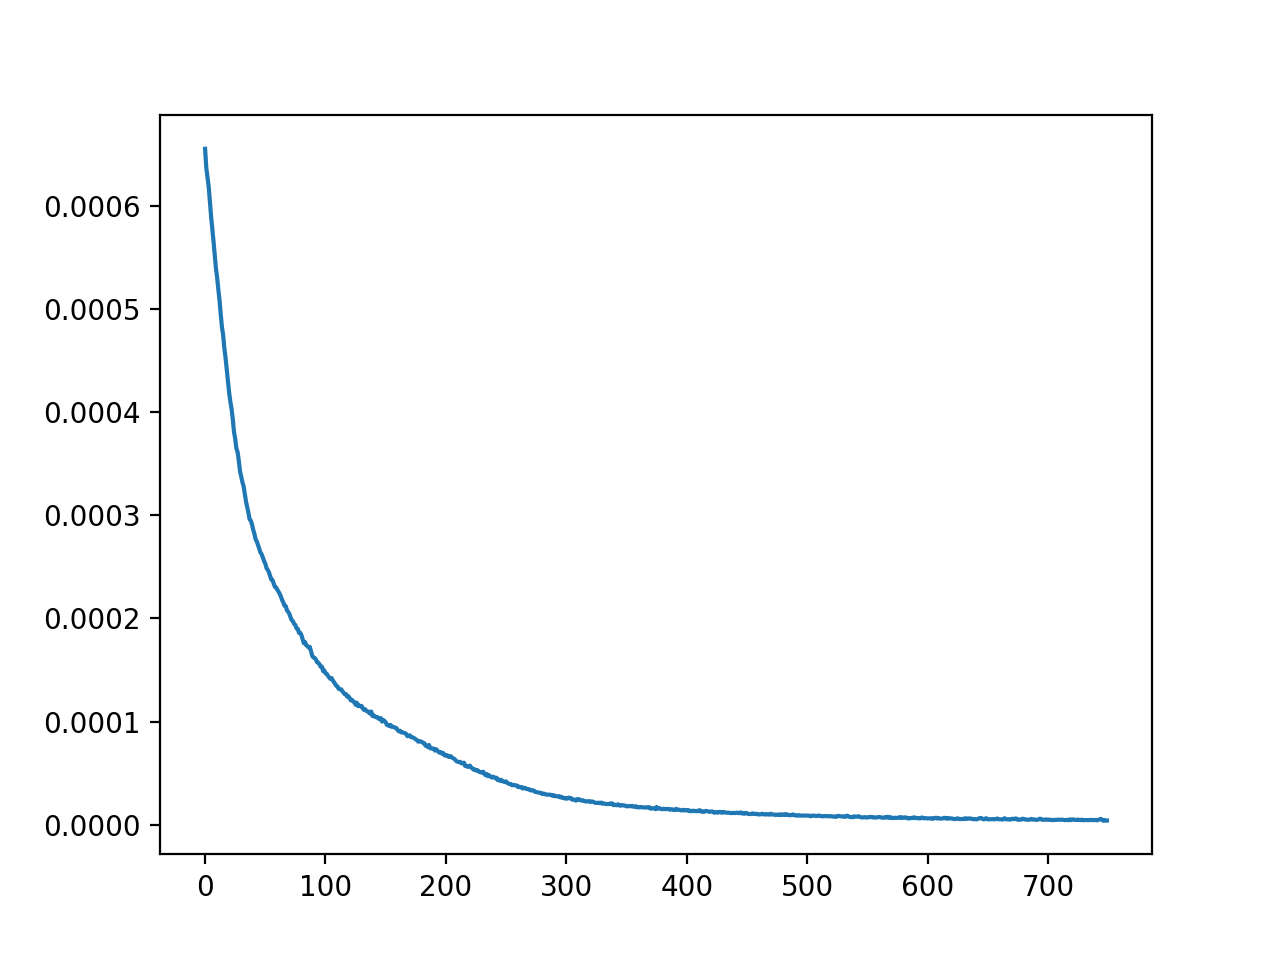

In [170]:
plt.figure()
plt.plot(history.history['loss'][50:])
plt.show()

**Save the models**

In [202]:
model.save('anomaly_detection_full_model.h5')
encoder_model.save('anomaly_detection_encoder_model.h5')

**Load the models**

Run this cell if you want to load previously trained models

In [21]:
#model = load_model('anomaly_detection_full_model.h5')
#encoder_model = load_model('anomaly_detection_encoder_model.h5')

## Establish Criteria for Anomalies

The autoencoder network is trained using normal data where it first compresses the input data and then reconstructs the input data. During training the network learns the interactions between various input variables under normal conditions and learns to reconstruct the input variables back to their original values. The reconstruction error is the error is reproducing back the original input values. We will be using `Mean Absolute Error` as our measure for the reconstruction error. The basic idea behind anomaly detection is that the reconstruction error using the trained network for anomalous inputs will be higher than what is typically observed with normal data. 

Thus, one of the parameters we need to understand is the **threshold for the reconstruction error** that identifies anomalous input data.

**Compute reconstruction errors for the normal dataset**

Next, we will make predictions on the normal dataset, compute the reconstruction error for individual set of inputs, and look that the upper and lower bounds for the reconstruction errors.

In [25]:
X_pred = model.predict(X_train)
loss_mae = np.mean(np.abs(X_pred-X_train), axis = 1)
normal_df['loss_mae'] = loss_mae
stats = normal_df.loss_mae.describe()
whis = 2.0
upper_bound = (whis* (stats['75%'] - stats['25%']) + stats['75%'])
lower_bound = (-whis* (stats['75%'] - stats['25%']) + stats['25%'])
print(('Mean Absolute Error: lower bound: {}, upper bound: {}').format(lower_bound, upper_bound))

Mean Absolute Error: lower bound: -0.0003492228101155603, upper bound: 0.0030489007137002753


**Visualize the reconstruction errors for the normal dataset**

It appears that the threshold value of `0.0030489007137002753` is a reasonable cutoff to identify anomalous input data.

<IPython.core.display.Javascript object>


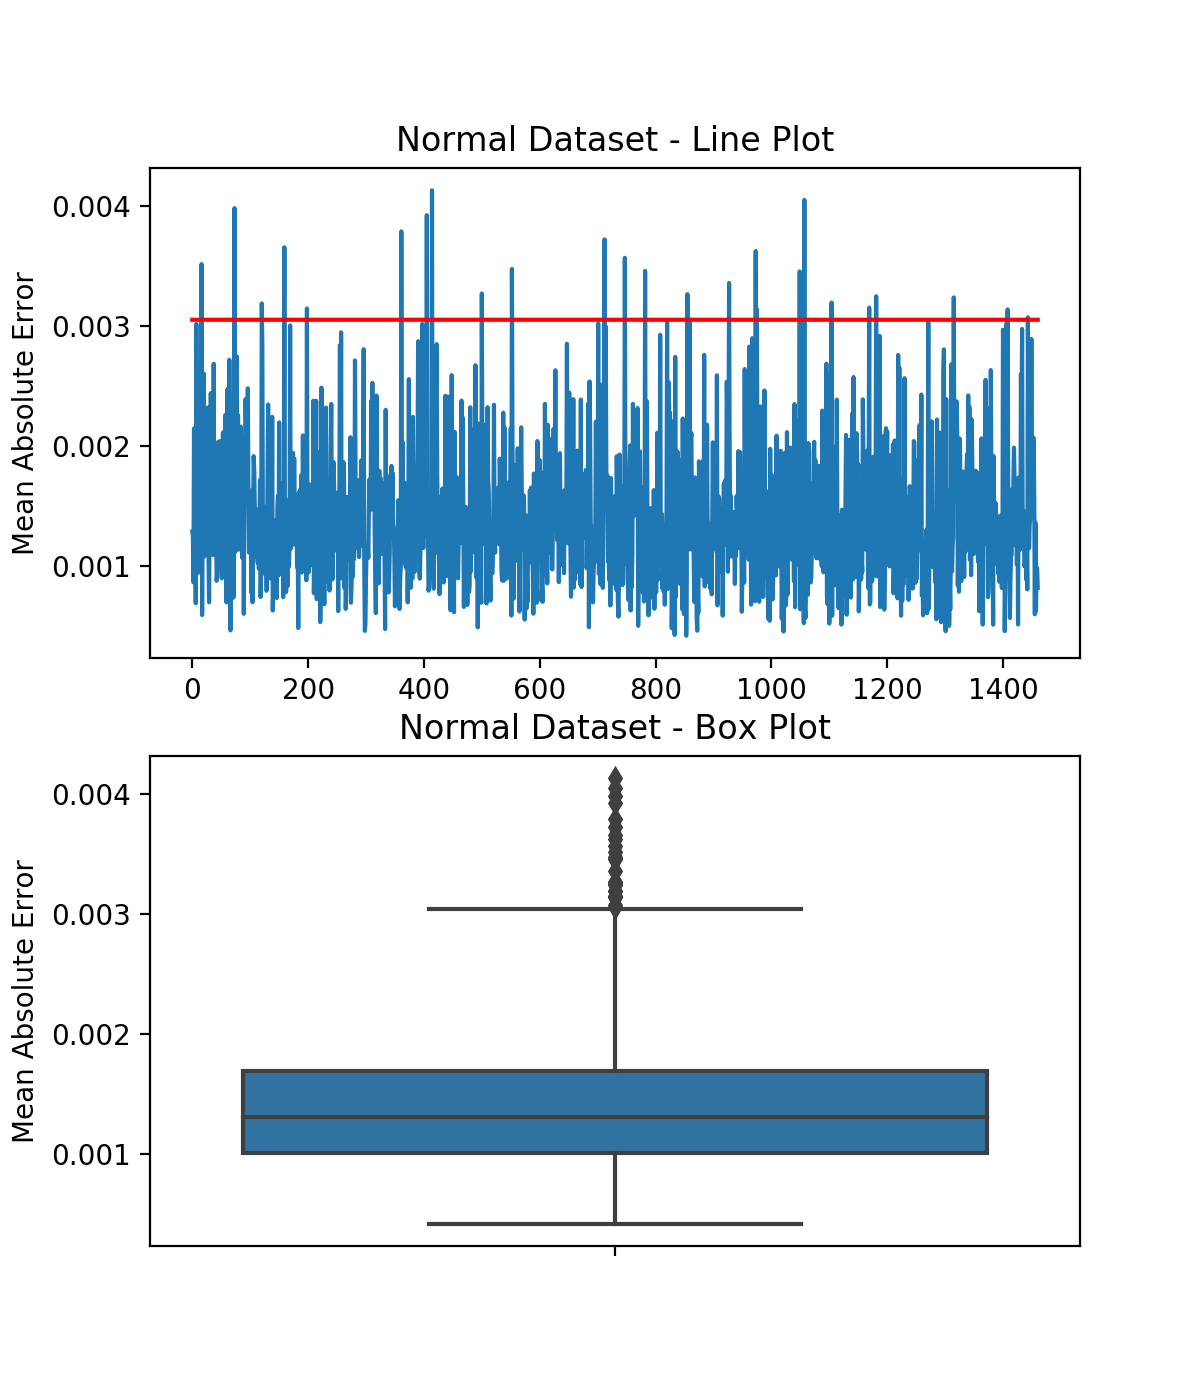

Text(0, 0.5, 'Mean Absolute Error')

In [27]:
f, ax = plt.subplots(2, 1, sharey=False, sharex=False, figsize=(6, 7))

upper_boundary = upper_bound * np.ones(len(loss_mae))

ax[0].plot(loss_mae)
ax[0].plot(upper_boundary, color='r')
sns.boxplot(y=loss_mae, whis=whis, ax = ax[1])

ax[0].set_title('Normal Dataset - Line Plot')
ax[1].set_title('Normal Dataset - Box Plot')
ax[0].set_ylabel('Mean Absolute Error')
ax[1].set_ylabel('Mean Absolute Error')

**Visualize the reconstruction errors for the sudden and gradual datasets**

The line plots show the anomalous regions in the two respective datasets.  For the sudden dataset there is an almost instantaneous spike and for the gradual dataset there is a ramp up to the peak error value.

In [28]:
X_sudden = clf.transform(sudden_df[feature_cols])
X_sudden_pred = model.predict(X_sudden)
loss_mae_sudden = np.mean(np.abs(X_sudden-X_sudden_pred), axis = 1)

X_gradual = clf.transform(gradual_df[feature_cols])
X_gradual_pred = model.predict(X_gradual)
loss_mae_gradual = np.mean(np.abs(X_gradual-X_gradual_pred), axis = 1)

<IPython.core.display.Javascript object>


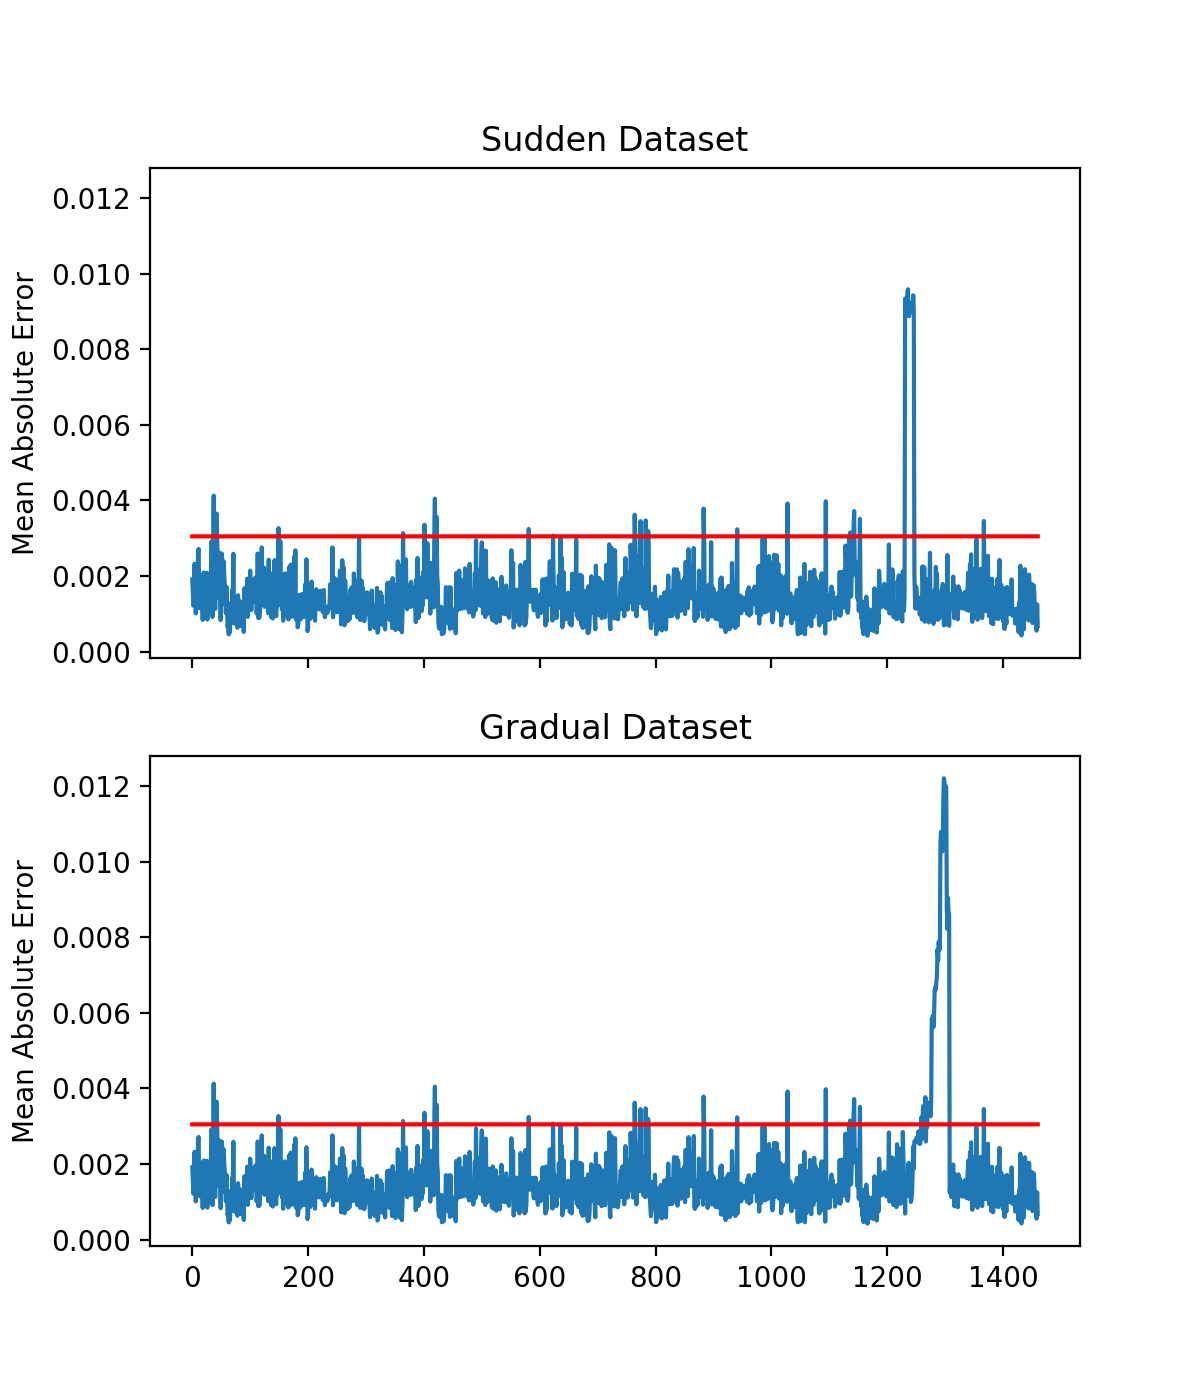

Text(0, 0.5, 'Mean Absolute Error')

In [30]:
f, ax = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(6, 7))

upper_boundary = upper_bound * np.ones(len(loss_mae_sudden))

ax[0].plot(loss_mae_sudden)
ax[0].plot(upper_boundary, color='r')
ax[1].plot(loss_mae_gradual)
ax[1].plot(upper_boundary, color='r')

ax[0].set_title('Sudden Dataset')
ax[1].set_title('Gradual Dataset')
ax[0].set_ylabel('Mean Absolute Error')
ax[1].set_ylabel('Mean Absolute Error')

**Zoom in to review the trends in the anomalous period**

Let’s review the reconstruction errors during the period of May 2019 to August 2019.

In [33]:
sudden_test_df = sudden_df.loc[lambda d: (d.date.dt.year == 2019) & 
                                ((d.date.dt.month == 5) | (d.date.dt.month == 6) | 
                                 (d.date.dt.month == 7) | (d.date.dt.month == 8)), :]

gradual_test_df = gradual_df.loc[lambda d: (d.date.dt.year == 2019) & 
                                ((d.date.dt.month == 5) | (d.date.dt.month == 6) | 
                                 (d.date.dt.month == 7) | (d.date.dt.month == 8)), :]

<IPython.core.display.Javascript object>


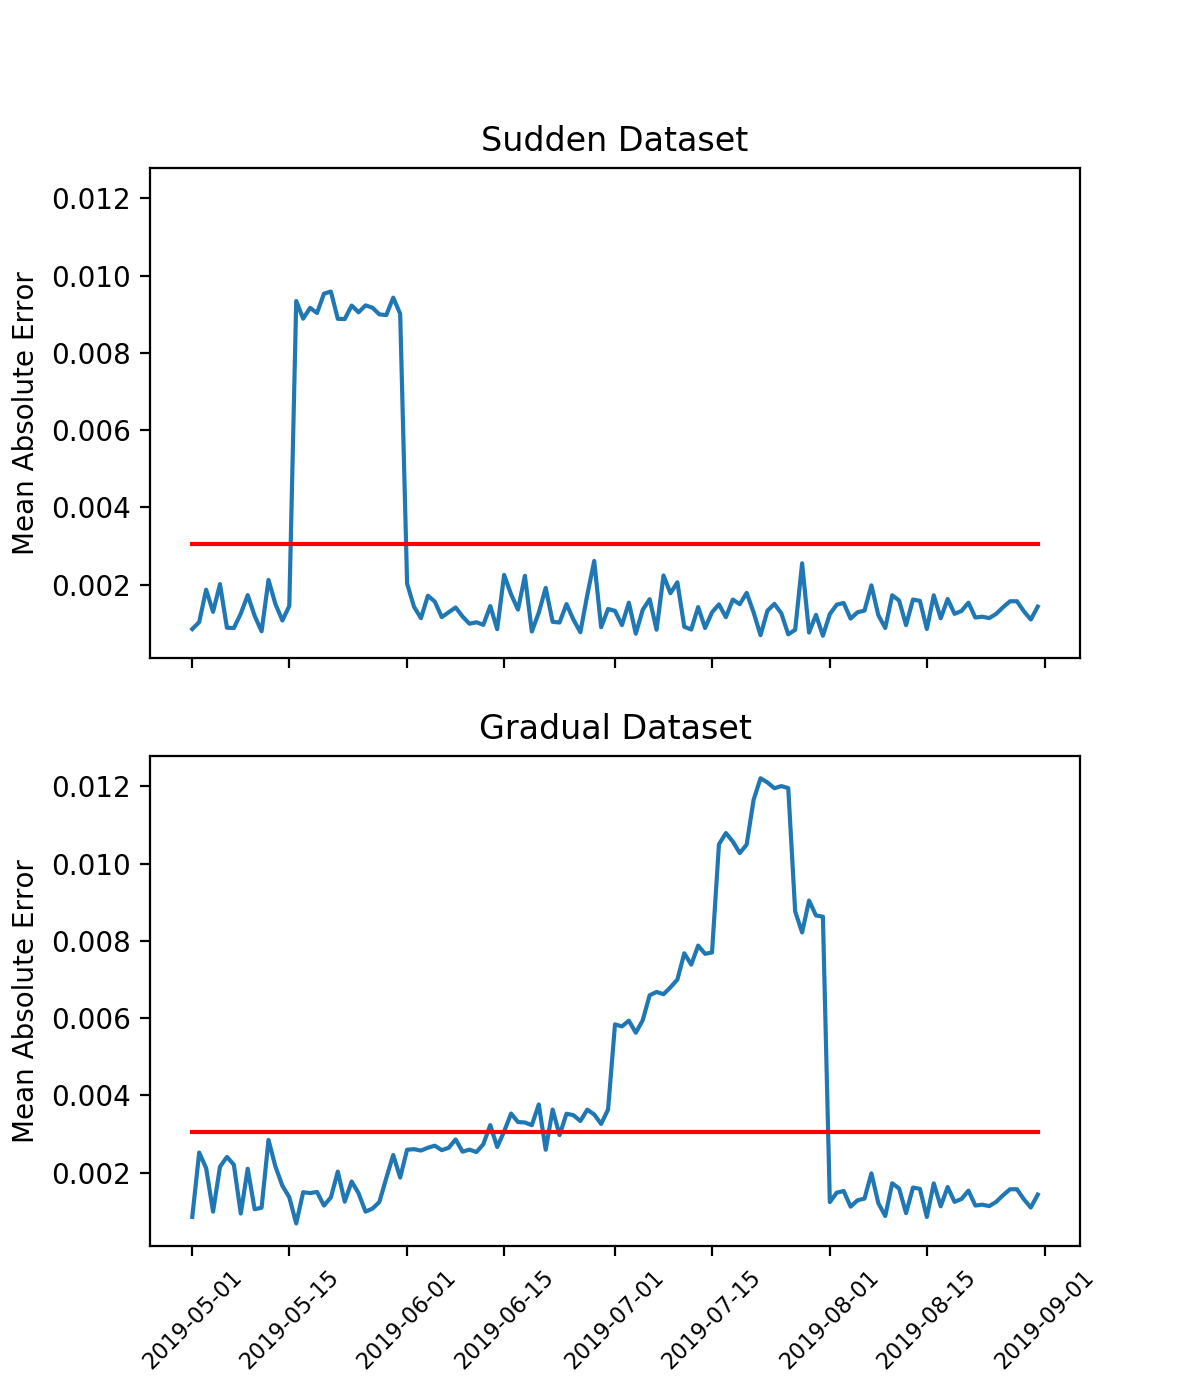

In [35]:
f, ax = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(6, 7))

upper_boundary = upper_bound * np.ones(len(sudden_test_df))

ax[0].plot(sudden_test_df.date, sudden_test_df.loss_mae.values)
ax[0].plot(sudden_test_df.date, upper_boundary, color='r')
ax[1].plot(sudden_test_df.date, gradual_test_df.loss_mae.values)
ax[1].plot(sudden_test_df.date, upper_boundary, color='r')
ax[0].set_title('Sudden Dataset')
ax[1].set_title('Gradual Dataset')
ax[0].set_ylabel('Mean Absolute Error')
ax[1].set_ylabel('Mean Absolute Error')
plt.xticks(fontsize=8, rotation=45);

**The question is for the gradual case, is there a lower error threshold we can monitor to detect the potential anomaly earlier in the time scale?**

#### Consecutive Counts Metric

`Consecutive Counts Metric` – is basically computing the number of consecutive errors that are above a given threshold in a real-time feed of time series data. The threshold here will be lower than the threshold monitored for anomalies. The idea is that for normal conditions while you may have occasional points above the lower threshold, that trend may not persist in subsequent readings unless the errors are gradually trending upwards towards anomalous conditions.

*Note that this is just one example to predict gradual anomalies earlier, and often you have either change or fine tune your approach to minimize false positives*

In [36]:
def consecutive_counts(df, col_name, threshold, start_index = 0):
    answer = []
    for i in range(start_index, len(df)):
        count = 0
        current_index = i
        current_value = df.iloc[current_index][col_name]
        while (current_index >= 0) & (current_value >= threshold):
            count = count + 1
            current_index = current_index - 1
            if (current_index >= 0):
                current_value = df.iloc[current_index][col_name]
        answer.append(count)
    return answer

In this example, we will use a lower threshold value of **0.0025** to compute the consecutive counts metric.

In [37]:
sudden_df['loss_mae'] = loss_mae_sudden
gradual_df['loss_mae'] = loss_mae_gradual

consecutive_threshold = 0.0025
normal_df['consecutive_counts'] = consecutive_counts(normal_df, 'loss_mae', consecutive_threshold)
sudden_df['consecutive_counts'] = consecutive_counts(sudden_df, 'loss_mae', consecutive_threshold)
gradual_df['consecutive_counts'] = consecutive_counts(gradual_df, 'loss_mae', consecutive_threshold)

## Predict Anomalies

With the two established thresholds: **0.0031** for point anomalies and **0.0025** for gradual (consecutive counts based) anomalies, we will add the two types of predictions to our data sets, standard point anomalies (`anomaly_std`), and anomalies based on consecutive counts metric (`anomaly_cc`). For the case of consecutive counts, we will use **5** consecutive readings above the lower threshold as start of anomalous conditions.

In [38]:
normal_df['anomaly_std'] = normal_df.loss_mae.apply(lambda x: True if x > upper_bound else False)
sudden_df['anomaly_std'] = sudden_df.loss_mae.apply(lambda x: True if x > upper_bound else False)
gradual_df['anomaly_std'] = gradual_df.loss_mae.apply(lambda x: True if x > upper_bound else False)

consecutive_counts_bound = 5
normal_df['anomaly_cc'] = normal_df.consecutive_counts.apply(lambda x: True if 
                                                             x >= consecutive_counts_bound else False)
sudden_df['anomaly_cc'] = sudden_df.consecutive_counts.apply(lambda x: True if 
                                                             x >= consecutive_counts_bound else False)
gradual_df['anomaly_cc'] = gradual_df.consecutive_counts.apply(lambda x: True if 
                                                               x >= consecutive_counts_bound else False)

**Review Anomalies in the Normal dataset**

The data set shows several point anomalies (`anomaly_std`), however we do not observe any consecutive counts (`anomaly_cc`) based anomalies.

In [182]:
display_dataframe(normal_df[(normal_df.anomaly_std == True) | (normal_df.anomaly_cc == True)])

**Review Anomalies in the Sudden dataset**

The data set shows a sudden jump in the reconstruction error (`loss_mae`) on May 16 2019 and it persists till end of May. The `anomaly_cc` starts, as expected, on the 4th day after `anomaly_std`.

In [183]:
display_dataframe(sudden_df[(sudden_df.anomaly_std == True) | (sudden_df.anomaly_cc == True)])

**Review Anomalies in the Gradual dataset**

The `anomaly_cc` starts on June 5th 2019 almost 8 days before the reconstruction error (`loss_mae`) exceeds the normal threshold.

In [184]:
display_dataframe(gradual_df[(gradual_df.anomaly_std == True) | (gradual_df.anomaly_cc == True)])

### Visualize Anomalies in the Observed Water Levels

Next, we will visualize the anomalies in the measured water levels during the anomalous period (May-August 2019).

As you can observe the **anomaly_std** works best in the case of **sudden anomalies**, whereas, the **anomaly_cc** works best in case of **gradual anomalies**.

In [39]:
sudden_test_df = sudden_df.loc[lambda d: (d.date.dt.year == 2019) & 
                                ((d.date.dt.month == 5) | (d.date.dt.month == 6) | 
                                 (d.date.dt.month == 7) | (d.date.dt.month == 8)), :]

gradual_test_df = gradual_df.loc[lambda d: (d.date.dt.year == 2019) & 
                                ((d.date.dt.month == 5) | (d.date.dt.month == 6) | 
                                 (d.date.dt.month == 7) | (d.date.dt.month == 8)), :]

<IPython.core.display.Javascript object>


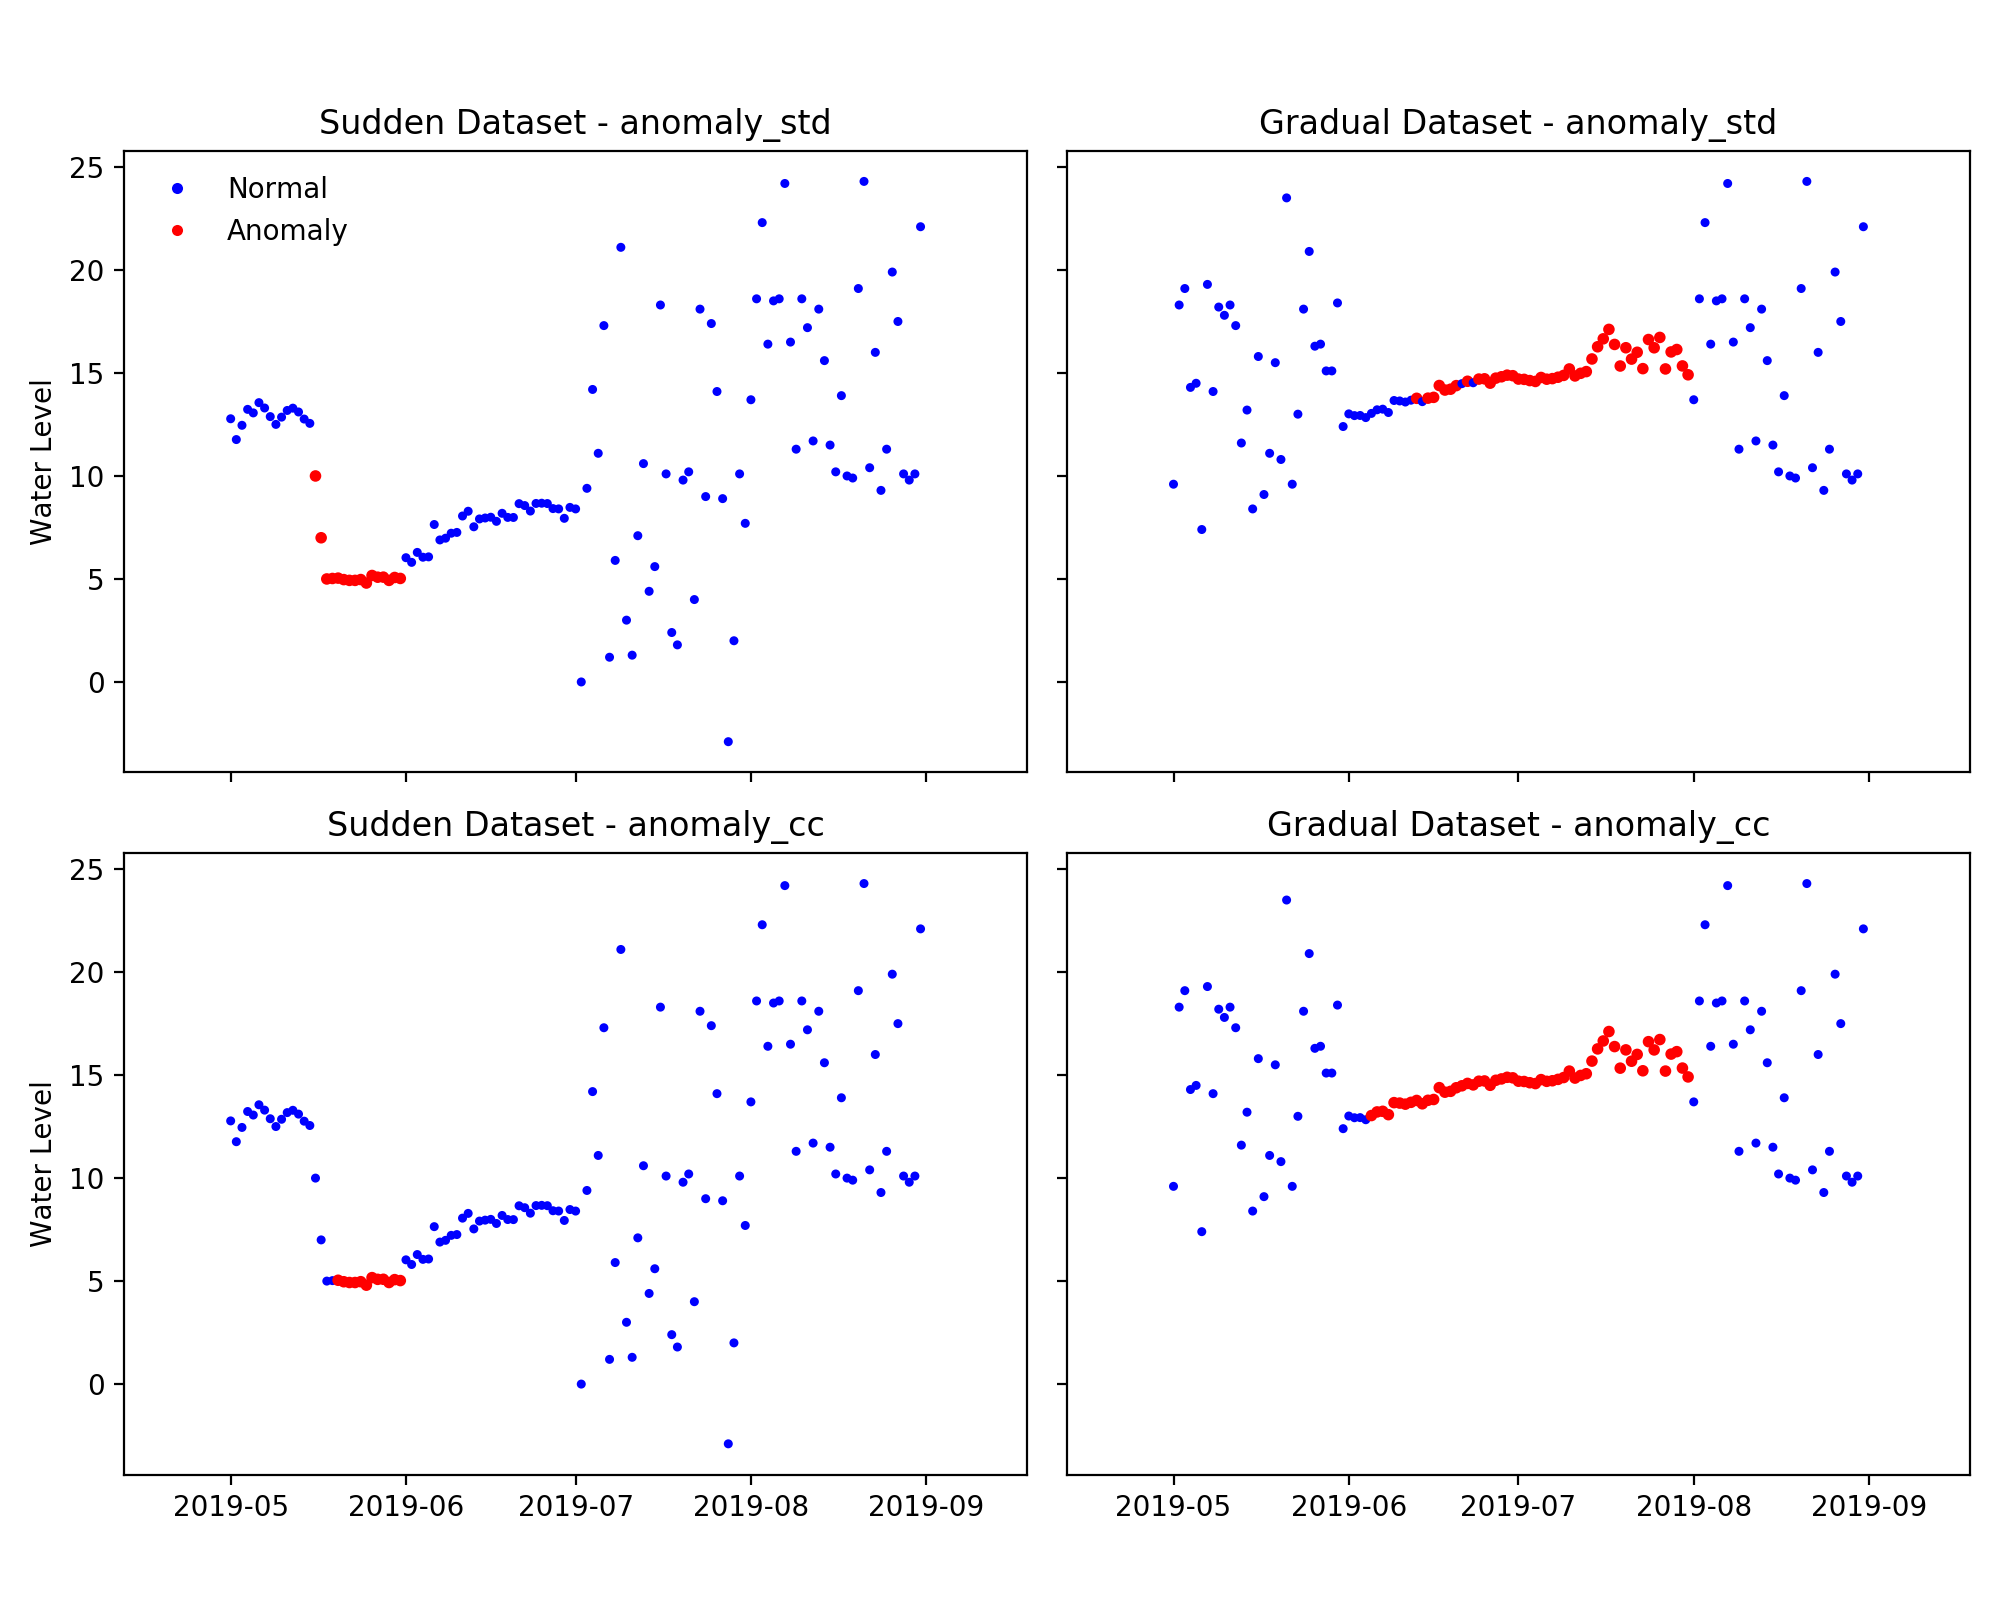

In [73]:
f, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 8))

colors_s_1 = ['red' if value == True else 'blue' for value in sudden_test_df.anomaly_std.values]
size_s_1 = [10 if value == True else 5 for value in sudden_test_df.anomaly_std.values]
colors_s_2 = ['red' if value == True else 'blue' for value in sudden_test_df.anomaly_cc.values]
size_s_2 = [10 if value == True else 5 for value in sudden_test_df.anomaly_cc.values]

colors_g_1 = ['red' if value == True else 'blue' for value in gradual_test_df.anomaly_std.values]
size_g_1 = [10 if value == True else 5 for value in gradual_test_df.anomaly_std.values]
colors_g_2 = ['red' if value == True else 'blue' for value in gradual_test_df.anomaly_cc.values]
size_g_2 = [10 if value == True else 5 for value in gradual_test_df.anomaly_cc.values]

ax[0][0].scatter(sudden_test_df.date, sudden_test_df.water_level, s = size_s_1, c = colors_s_1)
ax[0][1].scatter(gradual_test_df.date, gradual_test_df.water_level, s = size_g_1, c = colors_g_1)
ax[1][0].scatter(sudden_test_df.date, sudden_test_df.water_level, s = size_s_2, c = colors_s_2)
ax[1][1].scatter(gradual_test_df.date, gradual_test_df.water_level, s = size_g_2, c = colors_g_2)

ax[0][0].set_title('Sudden Dataset - anomaly_std')
ax[1][0].set_title('Sudden Dataset - anomaly_cc')
ax[0][1].set_title('Gradual Dataset - anomaly_std')
ax[1][1].set_title('Gradual Dataset - anomaly_cc')
ax[0][0].set_ylabel('Water Level')
ax[1][0].set_ylabel('Water Level')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='b', markersize=5), 
                  Line2D([0], [0], marker='o', color='w', label='Anomaly', markerfacecolor='r', markersize=5)]

ax[0][0].legend(handles=legend_elements, frameon=False)
#ax[0][1].legend(handles=legend_elements, frameon=False)
#ax[1][0].legend(handles=legend_elements, frameon=False)
#ax[1][1].legend(handles=legend_elements, frameon=False)

f.tight_layout(rect=[0, 0.03, 1, 0.95])

## Principal Component Analysis

Generate the top N principal components of the encoded representation of the input data for both the sudden and gradual datasets during the anomalous periods for each of the respective datasets.

In [53]:
sudden_anomalies = sudden_df.loc[lambda d: (d.date.dt.year == 2019) & (d.date.dt.month == 5), :]

gradual_anomalies = gradual_df.loc[lambda d: (d.date.dt.year == 2019) & 
                                   ((d.date.dt.month == 5) | (d.date.dt.month == 6) | 
                                    (d.date.dt.month == 7)), :]
sudden_anomalies_encoded = encoder_model.predict(clf.transform(sudden_anomalies[feature_cols]))
gradual_anomalies_encoded = encoder_model.predict(clf.transform(gradual_anomalies[feature_cols]))

Generate principal components for **N = [2, 3, 4, 5]**

In [54]:
pca_components = [2, 3, 4, 5]
sudden_anomalies_pca = []
gradual_anomalies_pca = []

def pca_analysis(input, results, anomaly_type):
    for comp in pca_components: 
        pca = PCA(n_components = comp)
        pca_result = pca.fit_transform(input)
        print('{} - Cumulative explained variation for {} principal components: {}'.format(
            anomaly_type, comp, np.sum(pca.explained_variance_ratio_)))
        results.append(pca_result)

pca_analysis(sudden_anomalies_encoded, sudden_anomalies_pca, 'Sudden anomalies')
pca_analysis(gradual_anomalies_encoded, gradual_anomalies_pca, 'Gradual anomalies')

Sudden anomalies - Cumulative explained variation for 2 principal components: 0.9939281940460205
Sudden anomalies - Cumulative explained variation for 3 principal components: 0.9998870491981506
Sudden anomalies - Cumulative explained variation for 4 principal components: 0.9999890327453613
Sudden anomalies - Cumulative explained variation for 5 principal components: 0.9999978542327881
Gradual anomalies - Cumulative explained variation for 2 principal components: 0.9989464282989502
Gradual anomalies - Cumulative explained variation for 3 principal components: 0.9995376467704773
Gradual anomalies - Cumulative explained variation for 4 principal components: 0.9998646974563599
Gradual anomalies - Cumulative explained variation for 5 principal components: 0.9999907612800598


### Visualize the Principal Components for N = 3

Visualize the top 3 principal components of the encoded representation of the input data.

The 3-D plots show a clean separation between normal and anomalous points in the sudden dataset, whereas, for the gradual dataset you see a gradual separation at first then followed by a clean separation between the normal and anomalous points.

<IPython.core.display.Javascript object>


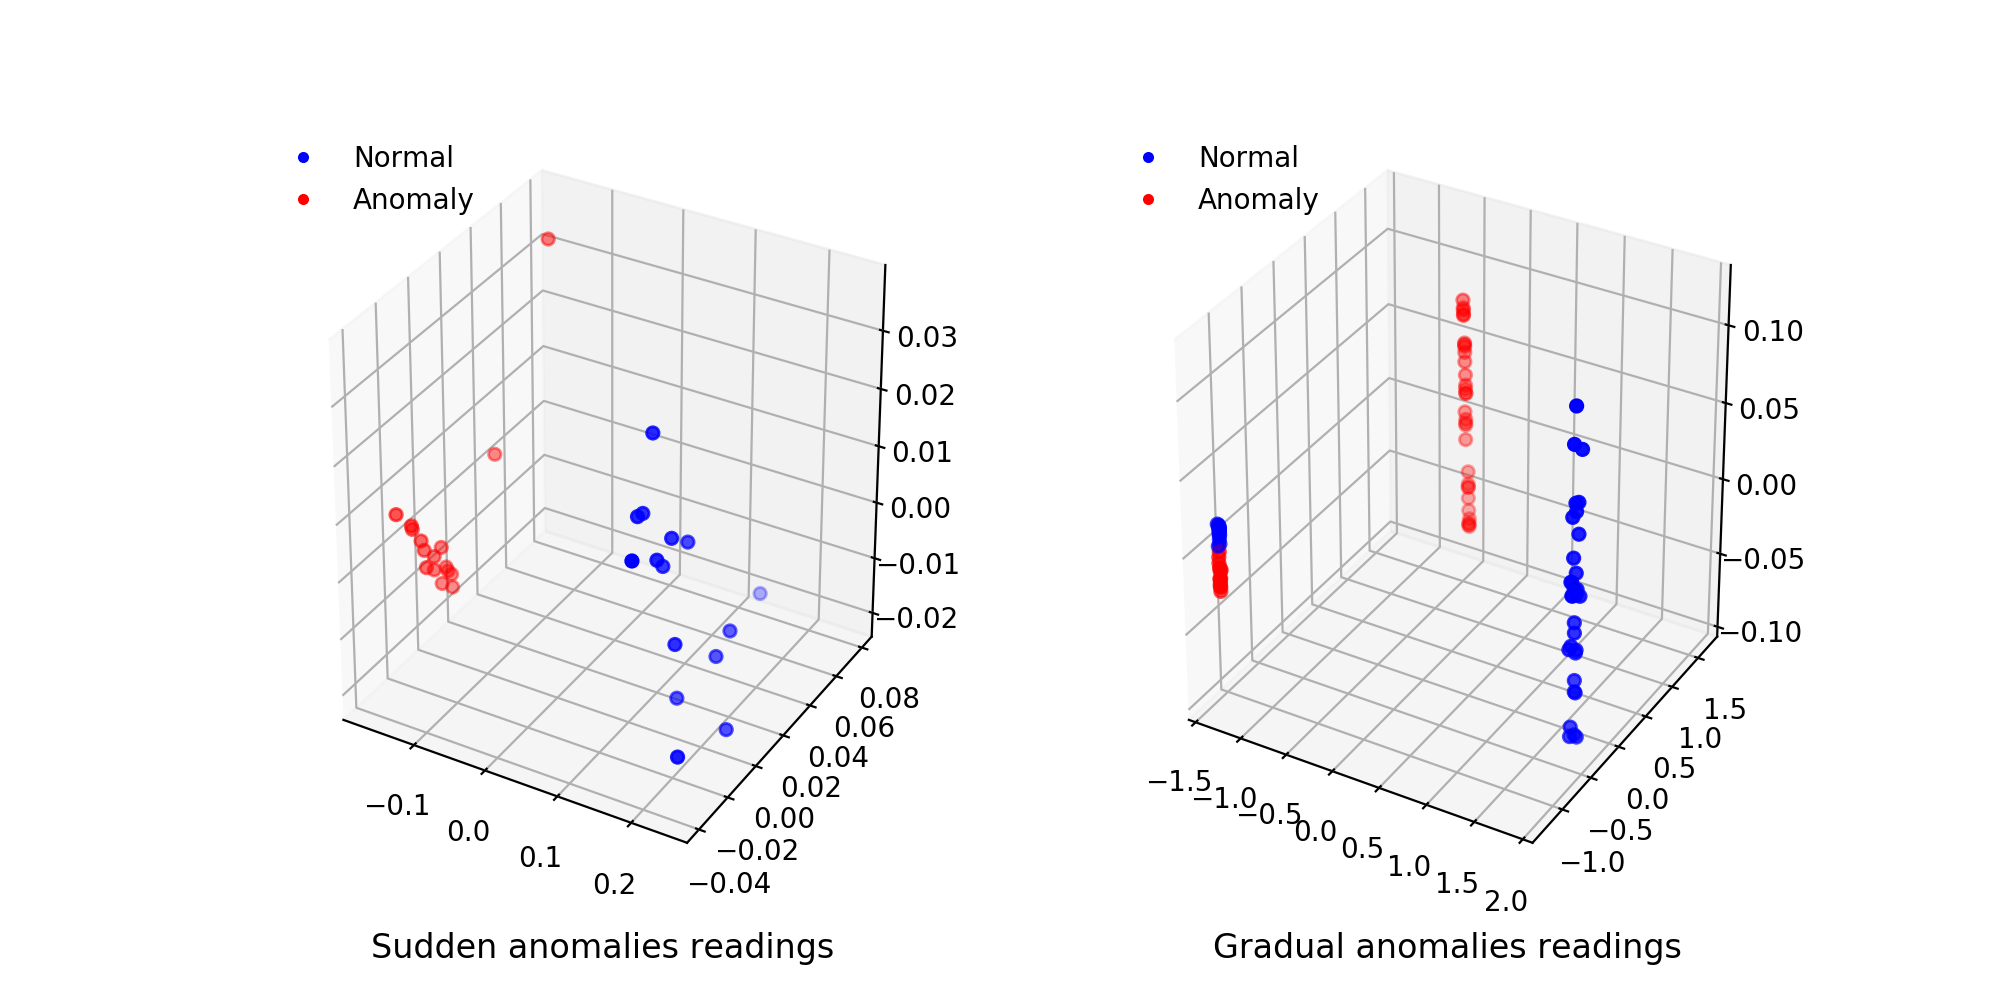

In [72]:
X_embedded1 = pd.DataFrame(sudden_anomalies_pca[1], columns=['X','Y', 'Z'])
X_embedded1['State'] = np.where(sudden_anomalies.anomaly_std, 'Failure', 'Normal')

X_embedded2 = pd.DataFrame(gradual_anomalies_pca[1], columns=['X','Y', 'Z'])
X_embedded2['State'] = np.where(gradual_anomalies.anomaly_std, 'Failure', 'Normal')

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title('Sudden anomalies readings', y=-0.12)
ax2.set_title('Gradual anomalies readings', y=-0.12)

colors_1 = ['red' if value == 'Failure' else 'blue' for value in X_embedded1.State.values]
ax1.scatter(X_embedded1.X.values, X_embedded1.Y.values, X_embedded1.Z.values, c=colors_1)

colors_2 = ['red' if value == 'Failure' else 'blue' for value in X_embedded2.State.values]
ax2.scatter(X_embedded2.X.values, X_embedded2.Y.values, X_embedded2.Z.values, c=colors_2)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='b', markersize=5), 
                  Line2D([0], [0], marker='o', color='w', label='Anomaly', markerfacecolor='r', markersize=5)]

ax1.legend(handles=legend_elements, loc='upper left', frameon=False)
ax2.legend(handles=legend_elements, loc='upper left', frameon=False)

plt.show()